# 4.2-a How does the number of classes affect accuracy?

In [4]:
import os
import datetime
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset

In [5]:
tf.__version__, tf.keras.__version__

('1.14.0', '2.2.4-tf')

In [6]:
tf.test.is_gpu_available(), tf.test.is_built_with_cuda()

(False, False)

In [7]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.2a-nclasses'

In [8]:
rawset = Dataset.new_from_folders(raw_dataset_folder)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset = rawset.filter_min_max(200, 200)

In [10]:
def train_nclasses(rawset, reporter, iterations=1):
    for it in range(iterations):
        for n in range(2, len(rawset.categories)+1):
            cats = random.sample(rawset.by_category().keys(), n)
            print(n, cats)
            myset = rawset.filter(lambda x: rawset.category_from(x) in cats)
            myset.rebuild_categories()
            tset, vset = myset.rnd_split_fraction_by_category(0.5)

            model = models.C256_16_16_L128_D(
                n, 256, 'softmax', 'categorical_crossentropy')
            result = Trainer(
                model,
                xs_encoder='one_hot',
                batch_size=100,
                steps_per_epoch=n,
                validation_steps=n*2,
                patience=10,
            ).train(tset, vset)
            r.line(n=n,
                cats=','.join(cats),
                val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1],
            )

# Train models

In [24]:
r = report.Reporter2(result_dir + '/nclasses.tsv')
train_nclasses(rawset, r, 5)
r.close()

2 ['pptx', 'gif']
3 ['kml', 'csv', 'pps']
4 ['rtf', 'unk', 'text', 'swf']
5 ['swf', 'hlp', 'eps', 'f', 'rtf']
6 ['unk', 'gz', 'dwf', 'xml', 'csv', 'ppt']
7 ['log', 'html', 'wp', 'text', 'dbase3', 'dwf', 'java']
8 ['unk', 'jpg', 'kml', 'ppt', 'swf', 'gz', 'eps', 'csv']
9 ['sql', 'wp', 'gif', 'hlp', 'png', 'csv', 'dbase3', 'xml', 'java']
10 ['swf', 'sql', 'pptx', 'wp', 'gz', 'log', 'doc', 'xml', 'dwf', 'ppt']
11 ['jpg', 'txt', 'hlp', 'gif', 'doc', 'xls', 'unk', 'rtf', 'log', 'kml', 'eps']
12 ['txt', 'kml', 'ps', 'pptx', 'html', 'xml', 'wp', 'csv', 'sql', 'java', 'f', 'rtf']
13 ['sql', 'dbase3', 'html', 'gz', 'xls', 'swf', 'jpg', 'ppt', 'java', 'pptx', 'unk', 'text', 'doc']
14 ['pps', 'unk', 'ppt', 'gif', 'txt', 'kml', 'doc', 'rtf', 'dbase3', 'hlp', 'dwf', 'eps', 'xls', 'xml']
15 ['csv', 'hlp', 'dbase3', 'txt', 'pptx', 'doc', 'kmz', 'java', 'dwf', 'eps', 'pdf', 'html', 'text', 'wp', 'log']
16 ['xml', 'pps', 'f', 'kmz', 'java', 'xls', 'swf', 'png', 'log', 'kml', 'dbase3', 'ppt', 'jpg', 'ps

20 ['java', 'pps', 'hlp', 'gif', 'pdf', 'unk', 'swf', 'txt', 'kmz', 'doc', 'rtf', 'xls', 'html', 'csv', 'text', 'wp', 'pptx', 'gz', 'log', 'png']
21 ['text', 'txt', 'csv', 'xls', 'rtf', 'eps', 'png', 'sql', 'unk', 'kml', 'wp', 'html', 'hlp', 'pptx', 'gif', 'java', 'kmz', 'swf', 'gz', 'ppt', 'log']
22 ['text', 'dwf', 'hlp', 'wp', 'xls', 'rtf', 'gz', 'pps', 'unk', 'kmz', 'gif', 'swf', 'pptx', 'csv', 'png', 'ps', 'jpg', 'f', 'pdf', 'kml', 'eps', 'html']
23 ['kml', 'eps', 'xls', 'gz', 'rtf', 'wp', 'sql', 'jpg', 'dbase3', 'java', 'hlp', 'text', 'gif', 'txt', 'pptx', 'doc', 'ps', 'f', 'dwf', 'kmz', 'ppt', 'unk', 'log']
24 ['wp', 'html', 'xls', 'pps', 'pdf', 'doc', 'dbase3', 'csv', 'hlp', 'txt', 'java', 'text', 'ppt', 'png', 'log', 'gif', 'kml', 'xml', 'dwf', 'pptx', 'gz', 'ps', 'swf', 'sql']
25 ['kml', 'jpg', 'gif', 'wp', 'dwf', 'kmz', 'csv', 'f', 'ppt', 'xls', 'gz', 'doc', 'log', 'unk', 'png', 'html', 'pdf', 'dbase3', 'xml', 'eps', 'text', 'hlp', 'java', 'pps', 'sql']
26 ['kmz', 'jpg', 'jav

# Load data

In [73]:
data = pd.read_csv(result_dir + '/nclasses.tsv', sep='\t')
data

,n,cats,val_categorical_accuracy
0,2,"wp,hlp",0.962500
1,3,"pps,eps,text",0.823375
2,4,"text,rtf,eps,doc",0.777750
3,5,"wp,csv,gz,txt,f",0.782000
4,6,"html,wp,xls,csv,pdf,kml",0.892875
...,...,...,...
140,26,"kmz,jpg,java,swf,eps,pps,f,ppt,sql,hlp,gz,dbas...",0.459625
141,27,"xml,sql,kmz,ps,csv,doc,pdf,html,gif,eps,dbase3...",0.379125
142,28,"pps,ppt,swf,log,sql,dbase3,xml,eps,f,txt,kmz,d...",0.380125
143,29,"kmz,dbase3,unk,hlp,gz,pdf,pps,ps,doc,wp,kml,pp...",0.452500


In [79]:
data2 = pd.read_csv('results/4.2b-pairs/nclasses.tsv', sep='\t')
data2

,n,cats,val_categorical_accuracy
0,2,"dwf,jpg",0.558375
1,2,"pps,ppt",0.559125
2,2,"gz,jpg",0.560125
3,2,"png,pptx",0.567750
4,2,"png,swf",0.578750
...,...,...,...
373,2,"gz,hlp",0.999750
374,2,"gz,txt",0.999750
375,2,"gif,html",0.999875
376,2,"dbase3,gz",1.000000


In [84]:
mdata = pd.concat([data, data2])
mdata

,n,cats,val_categorical_accuracy
0,2,"wp,hlp",0.962500
1,3,"pps,eps,text",0.823375
2,4,"text,rtf,eps,doc",0.777750
3,5,"wp,csv,gz,txt,f",0.782000
4,6,"html,wp,xls,csv,pdf,kml",0.892875
...,...,...,...
373,2,"gz,hlp",0.999750
374,2,"gz,txt",0.999750
375,2,"gif,html",0.999875
376,2,"dbase3,gz",1.000000


In [176]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right'):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels is None:
        labels = [None for x in xs]
    for x, y, label, mark in zip(xs, ys, labels, ['bx', 'g-', 'r*', '.mD']):
        plt.plot(x[x==2], y[x==2], mark, alpha=0.1, label='')
        plt.plot(x[x!=2], y[x!=2], mark, label=label)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')
    plt.show()

In [177]:
def f():
    fac = 1/data['n']
    return (data['val_categorical_accuracy']-fac)/(1-fac)/2+0.5

In [178]:
def g(x):
    return (0.97**x-1/x)/(1-1/x)

In [179]:
x = range(2,31)

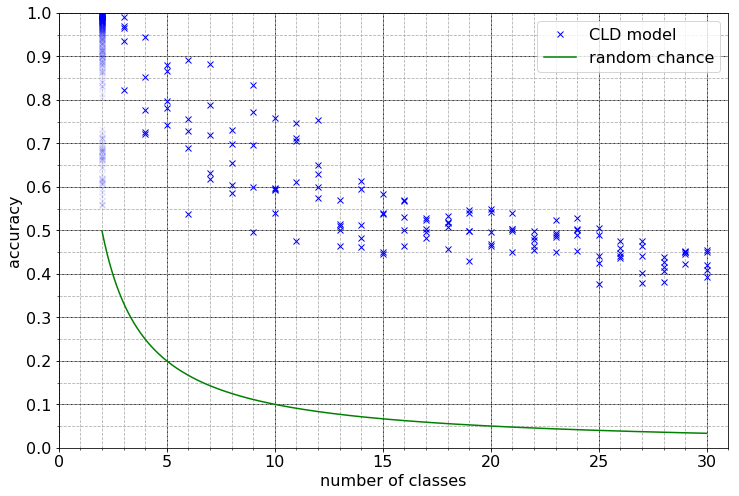

In [181]:
x = np.arange(2,30,0.01)
y = 1/x
plot_acc([mdata['n'], x], [mdata['val_categorical_accuracy'], y], ['CLD model', 'random chance'])